In this notebook we are going to see how one could compute statistics for certain geometric areas. Some potential usecases for this might be

- average temperature per country
- aggregate land cover per US state
- average population density per country

and many more. In order to compute zonal statistics, we generally need two things:

- a variable of interest defined on a raster image (i.e. one value per pixel)
- a set of geometries that define the relevant areas for aggregation

Although the focus should be on computation of zonal statistics, we will actually also take a quick view on what we can learn from our analysis data while we are at it. The example we are looking at is US land cover.

In [ ]:
# import geemap
import geemap.eefolium as geemap
import ee
import pandas as pd
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns

from egis.utils import (
    get_landcover_class_info
)

from egis.utils_plotting import make_outside_legend

In [ ]:
# Settings for charts
plt.rcParams["figure.figsize"] = 14, 6
sns.set()

### Variable of interest: US Land cover data

First we will load and visualize a US land cover dataset: [NLCD: USGS National Land Cover Database](https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD_RELEASES_2016_REL)

In [ ]:
Map = geemap.Map()

dataset = ee.Image('USGS/NLCD/NLCD2016')
landcover = ee.Image(dataset.select('landcover'))
Map.addLayer(landcover, {}, 'NLCD 2016')

lat = 40
lon = -84
Map.setCenter(lon, lat, 4)

Map.add_legend(builtin_legend='NLCD')

Map

Classified land cover will be our variable of interest. A more detailed legend with some explanations for the individual land cover classes can be found here: https://www.mrlc.gov/data/legends/national-land-cover-database-2019-nlcd2019-legend

The land cover dataset also includes some metadata with regards to the individual land cover classes. This metadata can be queried from the data. We are putting it into a `DataFrame` for later use. 

In [ ]:
landcover_data_info = landcover.getInfo()

In [ ]:
lc_class_info = get_landcover_class_info(landcover_data_info)
lc_class_info

### Geometries for aggregation: US states

Now we also need a set of geometric areas that we can use for aggregation. For this we will load the [TIGER: US Census States 2018](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_States#table-schema) dataset and visualize it.

In [ ]:
Map = geemap.Map()

states = ee.FeatureCollection("TIGER/2018/States")
Map.addLayer(states, {}, 'US States')

lat = 50
lon = -143
Map.setCenter(lon, lat, 3)

Map

As we can see, the tiger dataset also contains Alaska and other regions / islands apart from the contiguous US states. As we will see, these regions are not reflected in the US land cover dataset, so we will not be able to retrieve land cover statistics for them.

Apart from the geometric information the TIGER dataset contains some further metadata for individual observations:

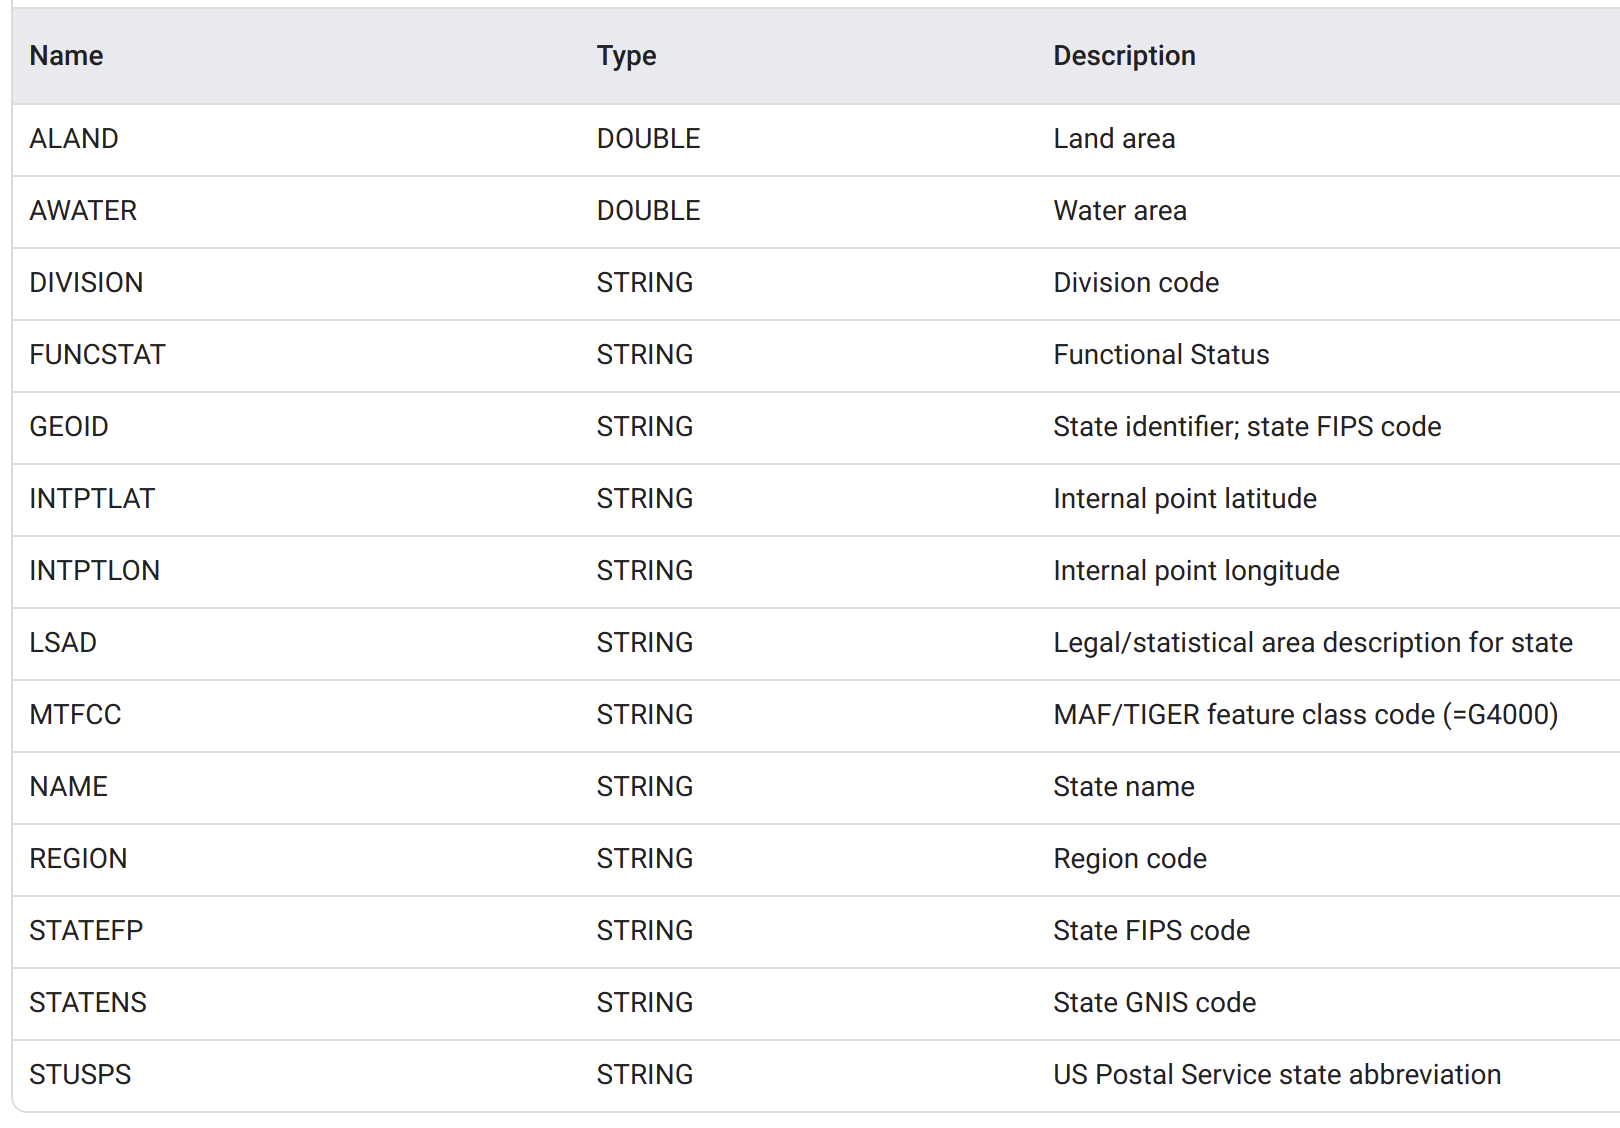

This metadata can be retrieved from the data itself:

In [ ]:
states_data_info = states.getInfo()
states_data_info['features'][0]['properties'].keys()

We will use `ALAND` and `AWATER` data later on in order to double-check our aggregate zonal statistics.

### Computation of zonal statistics

In order to query statistical data for the individual states we need to specify an output file to write to. We will just create a temporary file for this which we will immediately load into memory again for further analysis.

In [ ]:
out_file_path = tempfile.NamedTemporaryFile().name + '.csv'

In [ ]:
geemap.zonal_statistics_by_group(landcover, states, out_file_path, statistics_type='SUM', denominator=1000000, decimal_places=2)

When we read in the data again we will see that the statistics come with metadata columns attached.

In [ ]:
us_landcover_stats_raw = pd.read_csv(out_file_path)
us_landcover_stats_raw.head(3)

The zonal statistics also include a `Class_sum` column which contains the aggregate area of all individual land cover classes for each of the individual US regions. This column now can be used to cross-check numbers with the area sizes provided by the US states dataset.

In [ ]:
us_landcover_stats = us_landcover_stats_raw.set_index('NAME')
us_landcover_stats['approx_area'] = (us_landcover_stats['ALAND'] + us_landcover_stats['AWATER']) / 1000000
us_landcover_stats.loc[:, ['Class_sum', 'approx_area']].tail(5).round()

In [ ]:
us_landcover_stats.loc[:, ['Class_sum', 'approx_area']].plot(kind='bar')
plt.title('Cross-check for aggregate area numbers and each US state')
plt.xlabel('')
plt.show()

From the chart we can see two things. First, for some regions we get 0 as aggregate area derived from the land cover dataset. The reason for this is what we already mentioned above: land cover is only provided for the contiguous US states, but not for Hawaii, Alaska and other islands. Second, for all states where we do have land cover values the aggregate US state areas match almost perfectly. Hence, the zonal statistics seem to work as expected.

Now that we are confident about the zonal statistics data, let's first have a look at land cover statistics for the full US (except for Hawaii, ...). 

In [ ]:
existing_classes = [this_col for this_col in us_landcover_stats.columns if this_col in lc_class_info['class_name_statistics'].values]
us_landcover_class_stats = us_landcover_stats.loc[:, existing_classes]

In [ ]:
aggregate_us_land_cover = us_landcover_class_stats.sum(axis=0).reset_index()
aggregate_us_land_cover.columns = ['class_name_statistics', 'aggregate_area']
aggregate_us_land_cover = aggregate_us_land_cover.merge(lc_class_info)

In [ ]:
rel_aggregate_us_land_cover = aggregate_us_land_cover.loc[:, ['class_name', 'aggregate_area', 'color']].set_index(['class_name', 'color'])
rel_aggregate_us_land_cover = rel_aggregate_us_land_cover / rel_aggregate_us_land_cover.sum() * 100
rel_aggregate_us_land_cover = rel_aggregate_us_land_cover.sort_values('aggregate_area')
rel_aggregate_us_land_cover = rel_aggregate_us_land_cover.reset_index().set_index('class_name')

colors = rel_aggregate_us_land_cover['color'].values

In [ ]:
rel_aggregate_us_land_cover['aggregate_area'].plot(kind='barh', figsize=(12, 10), width=0.9, color=colors)
plt.xlabel('Covered area in percentages')
plt.ylabel('Land cover class')
plt.title('US land cover areas per individual land cover classes')
plt.show()

Next, we will analyse land cover areas for individual US states. But in order to make things slightly more manageable, we also aggregate land cover classes to slightly broader categories.

In [ ]:
# compute percentage land cover values
us_landcover_class_stats_rel = us_landcover_class_stats.div(us_landcover_class_stats.sum(axis=1), axis=0) * 100
us_landcover_class_stats_rel = us_landcover_class_stats_rel.dropna(axis=0)
us_landcover_class_stats_rel = us_landcover_class_stats_rel.reset_index().melt(id_vars='NAME')
us_landcover_class_stats_rel.columns = ['state', 'class_name_statistics', 'area_pct']
us_landcover_class_stats_rel = us_landcover_class_stats_rel.merge(lc_class_info).loc[:, ['state', 'area_pct', 'class_name', 'class_group_name']]

# aggregate values to land cover group classes
us_landcover_class_group_stats_rel = us_landcover_class_stats_rel.loc[:, ['state', 'area_pct', 'class_group_name']]
us_landcover_class_group_stats_rel = us_landcover_class_group_stats_rel.groupby(['state', 'class_group_name']).sum()
us_landcover_class_group_stats_rel = us_landcover_class_group_stats_rel.reset_index()

# transform to wide format
us_landcover_wide = us_landcover_class_group_stats_rel.pivot(index='state', columns='class_group_name', values='area_pct')
us_landcover_wide = us_landcover_wide.iloc[::-1]

# define color coding for group classes
color_lookup = lc_class_info.loc[:, ['class_group_name', 'class_group_color']].drop_duplicates().set_index('class_group_name')
colors = color_lookup.loc[us_landcover_wide.columns.values, 'class_group_color'].values

# visualize
ax = us_landcover_wide.plot(kind='barh', stacked=True, figsize=(14, 18), width=0.9, color=colors)

make_outside_legend(ax, vspace=-0.05)
plt.title('Land cover areas per US state and land cover type')
plt.xlabel('Covered area in percentages')
plt.show()

From the chart we can already see that US states differ significantly with regards to average land cover ratios. For example, states like Iowa and Illinois seem to be perfectly suited for agricultural production, while states like Arizona or Nevada consist predominantly of shrubland.

A different way to see this is by showing the three states with highest coverage for each individual land cover class:

In [ ]:
states_with_biggest_rel_area_per_class_type = us_landcover_class_group_stats_rel.sort_values(['class_group_name', 'area_pct']).groupby('class_group_name').tail(3).set_index('class_group_name')
states_with_biggest_rel_area_per_class_type

We can also visualize these values in a bar chart:

In [ ]:
color_dict = color_lookup.reset_index().sort_values('class_group_name').set_index('class_group_name').to_dict()['class_group_color']

In [ ]:
fig = plt.figure(figsize=(12, 10))

xx = states_with_biggest_rel_area_per_class_type.iloc[::-1].reset_index().reset_index()
colors = xx['class_group_name'].map(color_dict)
xx['color'] = colors

plt.barh(xx['index'], xx['area_pct'], color=xx['color'])

# Create names on the x-axis
plt.yticks(xx['index'], xx['state'])

colors = color_dict      
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=len(labels))

plt.title('Top 3 US states per land cover class')
plt.xlabel('Covered are in percetages')
plt.show()